# Practical Assesment Task #1: Colorizing Images with Generative Adversarial Networks
Técnicas Generativas y Aprendizaje por Refuerzo - Curso 2024/2025



## Import Dependencies and Set General Parameters

In [1]:
%pip install tensorflow -q
%pip install scikit-image -q

In [2]:
# Import libraries
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.layers import (
    Activation, AveragePooling2D, BatchNormalization, Conv2D, Dense,
    Dropout, Flatten, LeakyReLU, UpSampling2D)
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from time import time
from skimage.color import rgb2lab, lab2rgb
from pathlib import Path
from tqdm import tqdm

from tensorflow.keras.models import Sequential

# Enable memory growth for GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Constants
IMAGE_SIZE = 32
EPOCHS = 100 # Increase or decrease as appropriate
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 100

WORKDIR = "/content/drive/My Drive/Colab Notebooks/Workspace/"

# Create directories
Path(WORKDIR).mkdir(parents=True, exist_ok=True)
Path(f"{WORKDIR}/results").mkdir(parents=True, exist_ok=True)

## Define Dataset Loader

In [3]:
def generate_dataset(images, debug=False):
    """
    This function converts a list of RGB images to the LAB color space, and separates the L channel from the A and B channels.
    The images are normalized and reshaped to the appropriate dimensions for the model.

    Parameters:
    images (list): A list of RGB images
    debug (bool): If True, the function will display the original and converted images

    Returns:
    X (np.array): A numpy array of L channels of the images
    Y (np.array): A numpy array of A and B channels of the images
    """
    X = []
    Y = []

    for i in images:
        lab_image_array = rgb2lab(i / 255)  # Convert the image from RGB to LAB color space
        x = lab_image_array[:, :, 0]  # Get the L channel
        y = lab_image_array[:, :, 1:]  # Get the A and B channels
        y /= 128  # normalize

        if debug:  # If debug is True, display the original and converted images
            fig = plt.figure()
            fig.add_subplot(1, 2, 1)
            plt.imshow(i / 255)

            fig.add_subplot(1, 2, 2)
            plt.imshow(lab2rgb(np.dstack((x, y * 128))))
            plt.show()

        X.append(x.reshape(IMAGE_SIZE, IMAGE_SIZE, 1))  # Reshape the L channel and append to the list
        Y.append(y)  # Append the A and B channels to the list

    X = np.array(X, dtype=np.float32)  # Convert the list to a numpy array
    Y = np.array(Y, dtype=np.float32)  # Convert the list to a numpy array

    return X, Y


def load_data(force=False):
    """
    This function loads the CIFAR-10 dataset, processes it, and saves/loads the processed data to/from the disk.

    Parameters:
    force (bool): If True, the function will reprocess the data even if it already exists on the disk

    Returns:
    X_train, Y_train, X_test, Y_test (np.array): Numpy arrays of the training and testing data
    """
    is_saved_arrays_exist = os.path.isfile(os.path.join(WORKDIR, 'X_train.npy'))  # Check if the processed data already exists on the disk

    if not is_saved_arrays_exist or force:  # If the processed data does not exist or if force is True, process the data
        (train_images, _), (test_images, _) = cifar10.load_data()  # Load the CIFAR-10 dataset
        X_train, Y_train = generate_dataset(train_images)  # Process the training images
        X_test, Y_test = generate_dataset(test_images)  # Process the testing images
        print('Saving processed data to Drive')
        np.save(os.path.join(WORKDIR, 'X_train.npy'), X_train)  # Save the processed training data to the disk
        np.save(os.path.join(WORKDIR, 'Y_train.npy'), Y_train)  # Save the processed training data to the disk
        np.save(os.path.join(WORKDIR, 'X_test.npy'), X_test)  # Save the processed testing data to the disk
        np.save(os.path.join(WORKDIR, 'Y_test.npy'), Y_test)  # Save the processed testing data to the disk
    else:  # If the processed data exists and force is False, load the data from the disk
        print('Loading processed data from Drive')
        X_train = np.load(os.path.join(WORKDIR, 'X_train.npy'))  # Load the processed training data from the disk
        Y_train = np.load(os.path.join(WORKDIR, 'Y_train.npy'))  # Load the processed training data from the disk
        X_test = np.load(os.path.join(WORKDIR, 'X_test.npy'))  # Load the processed testing data from the disk
        Y_test = np.load(os.path.join(WORKDIR, 'Y_test.npy'))  # Load the processed testing data from the disk

    return X_train, Y_train, X_test, Y_test

## Load Dataset

In [4]:
# Load the processed training and testing data
X_train, Y_train, X_test, Y_test = load_data()

# Create TensorFlow datasets from the training and testing data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

# Shuffle the training dataset and batch both datasets
# SHUFFLE_BUFFER_SIZE determines the randomness of the shuffling
# BATCH_SIZE determines the number of samples that will be propagated through the network at once
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step
Saving processed data to Drive


## Define Generator Model

In [5]:
def build_generator_model():
    """
    This function builds the generator model for the GAN. The generator is responsible for generating new, fake images.
    It uses a series of Conv2D, BatchNormalization, and UpSampling2D layers.

    Returns:
    model (Sequential): The generator model
    """
    model = Sequential()  # Initialize the model

    # Downsampling (Extracción de características)
    model.add(Conv2D(64, (3,3), strides=2, padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(128, (3,3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(256, (3,3), strides=2, padding='same'))  # Ahora 4x4
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    # Upsampling (Reconstrucción)
    model.add(UpSampling2D(size=(2,2)))  # 4x4 → 8x8
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(UpSampling2D(size=(2,2)))  # 8x8 → 16x16
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(UpSampling2D(size=(2,2)))  # 16x16 → 32x32
    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    # Capa de salida
    model.add(Conv2D(2, (3,3), padding='same'))  # Salida con canales A y B
    model.add(Activation('tanh'))  # Salida en [-1,1]


    # COMPLETE

    # Suggested architecture:
    # Downsampling
        # Add a series of Conv2D layers followed by BatchNormalization layers
        # Conv2D layers are used for the convolution operation that extracts features from the input images
        # Conv2D layers with stride=1 preserve the dimensions of the image
        # Conv2D layers with stride=2 downsample the image (i.e., reduce the dimensions of the image by half)
        # BatchNormalization layers are used to normalize the activations of the previous layer at each batch
        # ReLU activation function is used to add non-linearity to the output of the previous layer
        # Padding is set to 'same' to preserve the dimensions of the image
        # Repeat this series of layers N times

    # Upsampling
        # UpSampling2D layer is used to increase the dimension of the image
        # Add as many UpSampling2D layers as Conv2D layers with stride=2 to upsample the image to its original dimensions
        # Add a series of Conv2D layers followed by BatchNormalization layers
        # BatchNormalization layers are used to normalize the activations of the previous layer at each batch
        # ReLU activation function is used to add non-linearity to the output of the previous layer

    # Output layer
        # Add a Conv2D layer with 2 filters to output the A and B LAB channels of the image
        # Activation layer is used to apply the tanh activation function to the output
        # tanh activation function is used because the pixels of the output images range from -1 to 1

    return model

## Define Discriminator Model

In [6]:
def build_discriminator_model():
    """
    This function builds the discriminator model for the GAN. The discriminator is responsible for distinguishing real images from fake ones.
    It is recommended to use a series of Conv2D, Dropout, AveragePooling2D, Flatten, Dense, LeakyReLU, BatchNormalization, and Activation layers to create the model.

    Returns:
    model (Sequential): The discriminator model
    """

    model = Sequential()  # Initialize the model

    # Bloques de convolución
    model.add(Conv2D(64, (3,3), strides=2, padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 2)))  # Canales A y B en LAB
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3,3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (3,3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    # Pooling y capas densas
    model.add(AveragePooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    # Capa de salida
    model.add(Dense(1, activation='sigmoid'))  # Salida en [0,1] (real o falsa)
    # COMPLETE

    # Suggested architecture:
    # Convolution blocks
        # Add a series of Conv2D layers followed by Dropout
        # Conv2D layers are used for the convolution operation that extracts features from the input images
        # Dropout layers are used to prevent overfitting by randomly setting a fraction rate of input units to 0 at each update during training time
        # Repeat this series of layers N times

    # Pooling and dense layers
        # AveragePooling2D layer is used to downscale the image spatially
        # Flatten layer is used to convert the 2D matrix of features into a vector that can be fed into a fully connected neural network classifier
        # Dense layers are the regular deeply connected neural network layers
        # LeakyReLU is a type of activation function that allows a small gradient when the unit is not active
        # BatchNormalization layers are used to normalize the activations of the previous layer at each batch
        # Dropout layers are used to prevent overfitting by randomly setting a fraction rate of input units to 0 at each update during training time

    # Output layer
        # Add a Dense layer with 1 unit to output the probability of the input image being real or synthetic
        # Activation layer is used to apply the sigmoid activation function to the output
        # sigmoid activation function is used because the output is a probability between 0 and 1

    return model

## Define Generator and Discriminator Loss Functions

In [7]:
# Define the weight of the GAN loss
gan_loss_weight = 1

# Define the regularization parameter for the generator's L2 loss
l2_lambda = 150

# Define the loss function for the discriminator
# Binary Cross Entropy is used as the loss function since we are dealing with a binary classification problem (real vs fake images)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
    """
    This function calculates the total loss for the discriminator.

    Parameters:
    disc_real_output (Tensor): The discriminator's prediction on the real images
    disc_generated_output (Tensor): The discriminator's prediction on the generated (fake) images

    Returns:
    total_disc_loss (Tensor): The total loss for the discriminator
    """

    # Cross entropy loss for real images (label 1 = real)
    real_loss = cross_entropy(tf.ones_like(disc_real_output), disc_real_output)

    # Cross entropy loss for generated (fake) images (label 0 = fake)
    fake_loss = cross_entropy(tf.zeros_like(disc_generated_output), disc_generated_output)

    # Total loss for the discriminator
    total_disc_loss = real_loss + fake_loss

    return total_disc_loss


def generator_loss(disc_generated_output, gen_output, target):
    """
    This function calculates the total loss for the generator.

    Parameters:
    disc_generated_output (Tensor): The discriminator's prediction on the generated (fake) images
    gen_output (Tensor): The generated (fake) images
    target (Tensor): The real images

    Returns:
    total_gen_loss (Tensor): The total loss for the generator
    gan_loss (Tensor): The GAN loss for the generator
    l2_loss (Tensor): The L2 loss for the generator
    """

    # GAN loss (objective: engañar al discriminador para que piense que la imagen generada es real)
    gan_loss = cross_entropy(tf.ones_like(disc_generated_output), disc_generated_output)

    # L2 Loss (Mean Squared Error entre la imagen generada y la imagen real)
    l2_loss = tf.reduce_mean(tf.square(target - gen_output))

    # Total Generator Loss (GAN loss ponderada + L2 regularización)
    total_gen_loss = gan_loss_weight * gan_loss + l2_lambda * l2_loss

    return total_gen_loss, gan_loss, l2_loss


## Build Generator and Discriminator Models

In [8]:
# Instantiate the generator and discriminator models
generator = build_generator_model()
discriminator = build_discriminator_model()

# Print out the model summaries
generator.summary()
discriminator.summary()

# Define the optimizers for the generator and discriminator
# Adam optimizer is used with a learning rate of 2e-4 and beta_1 (the exponential decay rate for the first moment estimates) of 0.5
# It is recommended to experiment with different values for the learning rate. Beta_1 value of 0.5 is recommended for GANs
# It is possible that the optimal learning rate for the generator and discriminator is different from each other
gen_learning_rate = 2e-4
gene_beta_1 = 0.5

disc_learning_rate = 2e-4
disc_beta_1 = 0.5

generator_optimizer = tf.keras.optimizers.Adam(gen_learning_rate, beta_1=gene_beta_1)
discriminator_optimizer = tf.keras.optimizers.Adam(disc_learning_rate, beta_1=disc_beta_1)

# Define the directory for storing the training checkpoints
checkpoint_dir = os.path.join(WORKDIR, 'training-checkpoints')
# Define the prefix for the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# Create a checkpoint object which will be used to save and load the models and optimizers
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
# Create a manager for the checkpoint object, which will be responsible for saving and loading the checkpoints
# max_to_keep parameter is set to 3, meaning that only the 3 most recent checkpoints will be kept
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 16, 16, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 32)          │          18,4

 Total params: 760,226 (2.90 MB)

 Trainable params: 758,882 (2.89 MB)

 Non-trainable params: 1,344 (5.25 KB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 64)          │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 899,137 (3.43 MB)

 Trainable params: 897,345 (3.42 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [9]:
# Define the directory and file for storing the TensorBoard summary logs
summary_log_file = os.path.join(
    WORKDIR, 'tf-summary', datetime.now().strftime("%Y%m%d-%H%M%S"))
# Create a summary writer for writing the summary logs
summary_writer = tf.summary.create_file_writer(summary_log_file)

@tf.function
def train_step(input_image, target, epoch):
    """
    This function performs one training step for the generator and discriminator.

    Parameters:
    input_image (Tensor): The input image
    target (Tensor): The target image
    epoch (int): The current epoch number

    Returns:
    gen_total_loss (Tensor): The total loss for the generator
    disc_loss (Tensor): The loss for the discriminator
    """

    # Open a GradientTape context for automatic differentiation
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_total_loss = 0  # Initialize the total loss for the generator
        gen_gan_loss = 0  # Initialize the GAN loss for the generator
        gen_l2_loss = 0  # Initialize the L2 loss for the generator
        disc_loss = 0  # Initialize the loss for the discriminator

        # Generate an image using the generator
        # (remember to set training=True, since during training time BatchNormalization layers are applied using the batch mean and variance)
        gen_output = generator(input_image, training=True)

        # Get the discriminator's predictions on the real and generated images
        # (remember to set training=True, since during training time BatchNormalization layers are applied using the batch mean and variance)
        disc_real_output = discriminator(target, training=True)
        disc_generated_output = discriminator(gen_output, training=True)

        # Calculate the losses for the generator and discriminator
        gen_total_loss, gen_gan_loss, gen_l2_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # Calculate the gradients of the generator's and discriminator's losses with respect to the trainable variables of each model
    # Use the gradient() method of the GradientTape object of each model to calculate the gradients of the losses with respect to the trainable variables of the corresponding model
    gen_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply the gradients to the model's trainable variables
    # Use the apply_gradients() method of the optimizer object to apply the gradients
    # The apply_gradients() method takes a list of (gradient, variable) pairs
    # zip() function can be used to iterate over two lists simultaneously (i.e., the gradients and the model's trainable variables)
    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    # Write the losses to the summary logs
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l2_loss', gen_l2_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

    return gen_total_loss, disc_loss


In [10]:
# The checkpoint manager will load the latest checkpoint if it exists
# This will be used to resume training if the training process was interrupted
# If no checkpoint exists, the models will be initialized from scratch

# Restore the latest checkpoint using the checkpoint manager
checkpoint.restore(manager.latest_checkpoint)

# If a checkpoint was found and restored, print a message indicating the checkpoint file
if manager.latest_checkpoint:
    print('Restored from {}'.format(manager.latest_checkpoint))

# If no checkpoint was found, print a message indicating that the models are being initialized from scratch
else:
    print('Initializing from scratch')

Initializing from scratch


In [11]:
# Loop over the epochs
for e in tqdm(range(EPOCHS)):
    # Record the start time of the epoch
    start_time = time()

    gen_loss_total = 0  # Initialize the total loss for the generator
    disc_loss_total = 0  # Initialize the total loss for the discriminator

    # Loop over the training dataset
    for input_image, target in train_dataset:
        # Perform one training step and get the generator and discriminator losses
        gen_loss, disc_loss = train_step(input_image, target, e)

        # Add the losses to the total losses
        gen_loss_total += gen_loss
        disc_loss_total += disc_loss

    # Calculate the time taken for the epoch
    time_taken = time() - start_time

    # If the epoch number is a multiple of 10, save a checkpoint
    if (e + 1) % 10 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    # Print the epoch number, average generator loss, average discriminator loss, and time taken
    print(f'Epoch {e + 1}: gen loss: {gen_loss_total / len(train_dataset)}, '
          f'disc loss: {disc_loss_total / len(train_dataset)}, time: {time_taken:.2f}s')


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
  1%|          | 1/100 [00:40<1:07:05, 40.67s/it]

Epoch 1: gen loss: 3.475008964538574, disc loss: 1.6402784585952759, time: 40.66s


  2%|▏         | 2/100 [01:10<55:36, 34.05s/it]  

Epoch 2: gen loss: 2.413015842437744, disc loss: 1.5042027235031128, time: 29.42s


  3%|▎         | 3/100 [01:40<52:37, 32.55s/it]

Epoch 3: gen loss: 2.3083267211914062, disc loss: 1.456633448600769, time: 30.77s


  4%|▍         | 4/100 [02:12<51:29, 32.18s/it]

Epoch 4: gen loss: 2.250373601913452, disc loss: 1.4260945320129395, time: 31.60s


  5%|▌         | 5/100 [02:44<51:05, 32.27s/it]

Epoch 5: gen loss: 2.2142770290374756, disc loss: 1.4082515239715576, time: 32.43s


  6%|▌         | 6/100 [03:16<50:02, 31.94s/it]

Epoch 6: gen loss: 2.190263271331787, disc loss: 1.39790678024292, time: 31.29s


  7%|▋         | 7/100 [03:46<48:44, 31.44s/it]

Epoch 7: gen loss: 2.175827980041504, disc loss: 1.3927525281906128, time: 30.41s


  8%|▊         | 8/100 [04:16<47:32, 31.00s/it]

Epoch 8: gen loss: 2.161821126937866, disc loss: 1.3899784088134766, time: 30.06s


  9%|▉         | 9/100 [04:47<47:06, 31.06s/it]

Epoch 9: gen loss: 2.152430772781372, disc loss: 1.3884904384613037, time: 31.19s


 10%|█         | 10/100 [05:18<46:29, 30.99s/it]

Epoch 10: gen loss: 2.141510486602783, disc loss: 1.3879090547561646, time: 30.46s


 11%|█         | 11/100 [05:48<45:25, 30.62s/it]

Epoch 11: gen loss: 2.132615566253662, disc loss: 1.3879529237747192, time: 29.76s


 12%|█▏        | 12/100 [06:19<45:08, 30.78s/it]

Epoch 12: gen loss: 2.129338502883911, disc loss: 1.3878401517868042, time: 31.13s


 13%|█▎        | 13/100 [06:50<44:28, 30.67s/it]

Epoch 13: gen loss: 2.1203858852386475, disc loss: 1.3874335289001465, time: 30.42s


 14%|█▍        | 14/100 [07:22<44:34, 31.10s/it]

Epoch 14: gen loss: 2.115020751953125, disc loss: 1.3876653909683228, time: 32.10s


 15%|█▌        | 15/100 [07:52<43:33, 30.74s/it]

Epoch 15: gen loss: 2.10649037361145, disc loss: 1.3873381614685059, time: 29.91s


 16%|█▌        | 16/100 [08:23<43:09, 30.83s/it]

Epoch 16: gen loss: 2.101675271987915, disc loss: 1.3874284029006958, time: 31.03s


 17%|█▋        | 17/100 [08:53<42:24, 30.66s/it]

Epoch 17: gen loss: 2.096543788909912, disc loss: 1.38776695728302, time: 30.24s


 18%|█▊        | 18/100 [09:24<41:56, 30.69s/it]

Epoch 18: gen loss: 2.090550661087036, disc loss: 1.3874527215957642, time: 30.75s


 19%|█▉        | 19/100 [09:55<41:31, 30.76s/it]

Epoch 19: gen loss: 2.080740213394165, disc loss: 1.3879998922348022, time: 30.92s


 20%|██        | 20/100 [10:25<41:02, 30.79s/it]

Epoch 20: gen loss: 2.0766286849975586, disc loss: 1.3874369859695435, time: 30.64s


 21%|██        | 21/100 [10:56<40:34, 30.81s/it]

Epoch 21: gen loss: 2.0696094036102295, disc loss: 1.3873347043991089, time: 30.86s


 22%|██▏       | 22/100 [11:30<41:02, 31.57s/it]

Epoch 22: gen loss: 2.0665736198425293, disc loss: 1.387369990348816, time: 33.32s


 23%|██▎       | 23/100 [12:00<40:14, 31.36s/it]

Epoch 23: gen loss: 2.061818838119507, disc loss: 1.3875943422317505, time: 30.86s


 24%|██▍       | 24/100 [12:31<39:29, 31.17s/it]

Epoch 24: gen loss: 2.0513598918914795, disc loss: 1.3877010345458984, time: 30.74s


 25%|██▌       | 25/100 [13:02<38:54, 31.12s/it]

Epoch 25: gen loss: 2.0447278022766113, disc loss: 1.3874496221542358, time: 31.01s


 26%|██▌       | 26/100 [13:35<38:59, 31.62s/it]

Epoch 26: gen loss: 2.0388247966766357, disc loss: 1.387607455253601, time: 32.78s


 27%|██▋       | 27/100 [14:05<37:51, 31.11s/it]

Epoch 27: gen loss: 2.031980037689209, disc loss: 1.3875904083251953, time: 29.93s


 28%|██▊       | 28/100 [14:36<37:26, 31.21s/it]

Epoch 28: gen loss: 2.024897575378418, disc loss: 1.3873720169067383, time: 31.42s


 29%|██▉       | 29/100 [15:07<36:52, 31.16s/it]

Epoch 29: gen loss: 2.0181884765625, disc loss: 1.387650489807129, time: 31.06s


 30%|███       | 30/100 [15:40<36:45, 31.51s/it]

Epoch 30: gen loss: 2.0104596614837646, disc loss: 1.387595295906067, time: 32.11s


 31%|███       | 31/100 [16:10<35:48, 31.13s/it]

Epoch 31: gen loss: 2.001678943634033, disc loss: 1.3875612020492554, time: 30.26s


 32%|███▏      | 32/100 [16:41<35:18, 31.15s/it]

Epoch 32: gen loss: 1.9944560527801514, disc loss: 1.387453317642212, time: 31.20s


 33%|███▎      | 33/100 [17:11<34:28, 30.87s/it]

Epoch 33: gen loss: 1.9875938892364502, disc loss: 1.3875428438186646, time: 30.21s


 34%|███▍      | 34/100 [17:43<34:05, 31.00s/it]

Epoch 34: gen loss: 1.9792636632919312, disc loss: 1.3874989748001099, time: 31.27s


 35%|███▌      | 35/100 [18:16<34:11, 31.56s/it]

Epoch 35: gen loss: 1.9672755002975464, disc loss: 1.3874669075012207, time: 32.88s


 36%|███▌      | 36/100 [18:46<33:27, 31.37s/it]

Epoch 36: gen loss: 1.9629184007644653, disc loss: 1.387497901916504, time: 30.92s


 37%|███▋      | 37/100 [19:19<33:14, 31.66s/it]

Epoch 37: gen loss: 1.9518675804138184, disc loss: 1.3874623775482178, time: 32.32s


 38%|███▊      | 38/100 [19:49<32:07, 31.09s/it]

Epoch 38: gen loss: 1.944867730140686, disc loss: 1.3877674341201782, time: 29.76s


 39%|███▉      | 39/100 [20:19<31:33, 31.05s/it]

Epoch 39: gen loss: 1.934594988822937, disc loss: 1.3872816562652588, time: 30.95s


 40%|████      | 40/100 [20:50<30:45, 30.76s/it]

Epoch 40: gen loss: 1.928120732307434, disc loss: 1.3875460624694824, time: 29.89s


 41%|████      | 41/100 [21:21<30:21, 30.87s/it]

Epoch 41: gen loss: 1.919800877571106, disc loss: 1.387373447418213, time: 31.13s


 42%|████▏     | 42/100 [21:51<29:35, 30.62s/it]

Epoch 42: gen loss: 1.9093047380447388, disc loss: 1.3872994184494019, time: 30.03s


 43%|████▎     | 43/100 [22:21<29:06, 30.64s/it]

Epoch 43: gen loss: 1.902416706085205, disc loss: 1.3874890804290771, time: 30.70s


 44%|████▍     | 44/100 [22:51<28:23, 30.42s/it]

Epoch 44: gen loss: 1.8931829929351807, disc loss: 1.3874200582504272, time: 29.91s


 45%|████▌     | 45/100 [23:24<28:36, 31.22s/it]

Epoch 45: gen loss: 1.88311767578125, disc loss: 1.3875834941864014, time: 33.06s


 46%|████▌     | 46/100 [23:55<27:56, 31.04s/it]

Epoch 46: gen loss: 1.8750094175338745, disc loss: 1.3873529434204102, time: 30.63s


 47%|████▋     | 47/100 [24:25<27:06, 30.69s/it]

Epoch 47: gen loss: 1.8656216859817505, disc loss: 1.3874646425247192, time: 29.85s


 48%|████▊     | 48/100 [24:55<26:31, 30.61s/it]

Epoch 48: gen loss: 1.858244776725769, disc loss: 1.3876583576202393, time: 30.42s


 49%|████▉     | 49/100 [25:26<26:01, 30.62s/it]

Epoch 49: gen loss: 1.8504284620285034, disc loss: 1.3874768018722534, time: 30.65s


 50%|█████     | 50/100 [25:57<25:37, 30.75s/it]

Epoch 50: gen loss: 1.8418817520141602, disc loss: 1.387272596359253, time: 30.83s


 51%|█████     | 51/100 [26:28<25:03, 30.68s/it]

Epoch 51: gen loss: 1.8325064182281494, disc loss: 1.3876820802688599, time: 30.53s


 52%|█████▏    | 52/100 [27:00<24:51, 31.06s/it]

Epoch 52: gen loss: 1.8263318538665771, disc loss: 1.3871612548828125, time: 31.95s


 53%|█████▎    | 53/100 [27:30<24:13, 30.93s/it]

Epoch 53: gen loss: 1.8172694444656372, disc loss: 1.3875762224197388, time: 30.61s


 54%|█████▍    | 54/100 [28:01<23:37, 30.82s/it]

Epoch 54: gen loss: 1.811005711555481, disc loss: 1.3874361515045166, time: 30.55s


 55%|█████▌    | 55/100 [28:31<22:56, 30.58s/it]

Epoch 55: gen loss: 1.8025670051574707, disc loss: 1.3875333070755005, time: 30.02s


 56%|█████▌    | 56/100 [29:01<22:25, 30.59s/it]

Epoch 56: gen loss: 1.7944083213806152, disc loss: 1.3876590728759766, time: 30.60s


 57%|█████▋    | 57/100 [29:31<21:45, 30.36s/it]

Epoch 57: gen loss: 1.789142370223999, disc loss: 1.3873891830444336, time: 29.84s


 58%|█████▊    | 58/100 [30:04<21:46, 31.10s/it]

Epoch 58: gen loss: 1.7807751893997192, disc loss: 1.387470006942749, time: 32.81s


 59%|█████▉    | 59/100 [30:35<21:20, 31.22s/it]

Epoch 59: gen loss: 1.772858738899231, disc loss: 1.3875802755355835, time: 31.49s


 60%|██████    | 60/100 [31:05<20:33, 30.83s/it]

Epoch 60: gen loss: 1.767162561416626, disc loss: 1.3873357772827148, time: 29.71s


 61%|██████    | 61/100 [31:36<19:58, 30.74s/it]

Epoch 61: gen loss: 1.7614432573318481, disc loss: 1.3874338865280151, time: 30.52s


 62%|██████▏   | 62/100 [32:06<19:20, 30.55s/it]

Epoch 62: gen loss: 1.7536486387252808, disc loss: 1.387433409690857, time: 30.09s


 63%|██████▎   | 63/100 [32:37<18:52, 30.61s/it]

Epoch 63: gen loss: 1.747074007987976, disc loss: 1.3876088857650757, time: 30.76s


 64%|██████▍   | 64/100 [33:08<18:24, 30.69s/it]

Epoch 64: gen loss: 1.7383853197097778, disc loss: 1.3874399662017822, time: 30.86s


 65%|██████▌   | 65/100 [33:40<18:13, 31.26s/it]

Epoch 65: gen loss: 1.7318787574768066, disc loss: 1.3873958587646484, time: 32.59s


 66%|██████▌   | 66/100 [34:11<17:35, 31.05s/it]

Epoch 66: gen loss: 1.7292344570159912, disc loss: 1.3873459100723267, time: 30.58s


 67%|██████▋   | 67/100 [34:41<17:00, 30.91s/it]

Epoch 67: gen loss: 1.721402645111084, disc loss: 1.38716721534729, time: 30.57s


 68%|██████▊   | 68/100 [35:12<16:25, 30.79s/it]

Epoch 68: gen loss: 1.7166047096252441, disc loss: 1.3874022960662842, time: 30.51s


 69%|██████▉   | 69/100 [35:44<16:05, 31.14s/it]

Epoch 69: gen loss: 1.7088189125061035, disc loss: 1.387616515159607, time: 31.92s


 70%|███████   | 70/100 [36:25<17:04, 34.14s/it]

Epoch 70: gen loss: 1.7073421478271484, disc loss: 1.3875832557678223, time: 40.94s


 71%|███████   | 71/100 [36:56<16:04, 33.27s/it]

Epoch 71: gen loss: 1.696735143661499, disc loss: 1.3875374794006348, time: 31.25s


 72%|███████▏  | 72/100 [37:27<15:14, 32.65s/it]

Epoch 72: gen loss: 1.6921697854995728, disc loss: 1.38739812374115, time: 31.18s


 73%|███████▎  | 73/100 [37:58<14:28, 32.17s/it]

Epoch 73: gen loss: 1.6859568357467651, disc loss: 1.3872438669204712, time: 31.02s


 74%|███████▍  | 74/100 [38:33<14:12, 32.78s/it]

Epoch 74: gen loss: 1.685941457748413, disc loss: 1.3874754905700684, time: 34.22s


 75%|███████▌  | 75/100 [39:03<13:23, 32.13s/it]

Epoch 75: gen loss: 1.6764373779296875, disc loss: 1.3874377012252808, time: 30.61s


 76%|███████▌  | 76/100 [39:34<12:42, 31.76s/it]

Epoch 76: gen loss: 1.6700133085250854, disc loss: 1.3872828483581543, time: 30.90s


 77%|███████▋  | 77/100 [40:15<13:13, 34.52s/it]

Epoch 77: gen loss: 1.6598329544067383, disc loss: 1.3872252702713013, time: 40.94s


 78%|███████▊  | 78/100 [40:47<12:19, 33.60s/it]

Epoch 78: gen loss: 1.6620146036148071, disc loss: 1.3874797821044922, time: 31.46s


 79%|███████▉  | 79/100 [41:18<11:31, 32.93s/it]

Epoch 79: gen loss: 1.6556779146194458, disc loss: 1.3876192569732666, time: 31.36s


 80%|████████  | 80/100 [41:48<10:42, 32.14s/it]

Epoch 80: gen loss: 1.6505032777786255, disc loss: 1.3873509168624878, time: 30.09s


 81%|████████  | 81/100 [42:20<10:05, 31.86s/it]

Epoch 81: gen loss: 1.6420300006866455, disc loss: 1.387554407119751, time: 31.21s


 82%|████████▏ | 82/100 [42:50<09:23, 31.33s/it]

Epoch 82: gen loss: 1.6408950090408325, disc loss: 1.3874282836914062, time: 30.05s


 83%|████████▎ | 83/100 [43:21<08:52, 31.31s/it]

Epoch 83: gen loss: 1.6336921453475952, disc loss: 1.3873285055160522, time: 31.28s


 84%|████████▍ | 84/100 [43:51<08:16, 31.00s/it]

Epoch 84: gen loss: 1.6322569847106934, disc loss: 1.387526273727417, time: 30.26s


 85%|████████▌ | 85/100 [44:23<07:48, 31.24s/it]

Epoch 85: gen loss: 1.6257565021514893, disc loss: 1.3872616291046143, time: 31.76s


 86%|████████▌ | 86/100 [44:54<07:18, 31.32s/it]

Epoch 86: gen loss: 1.623146891593933, disc loss: 1.3873345851898193, time: 31.53s


 87%|████████▋ | 87/100 [45:26<06:48, 31.45s/it]

Epoch 87: gen loss: 1.6195296049118042, disc loss: 1.3876445293426514, time: 31.72s


 88%|████████▊ | 88/100 [45:56<06:11, 30.99s/it]

Epoch 88: gen loss: 1.6172748804092407, disc loss: 1.3872321844100952, time: 29.94s


 89%|████████▉ | 89/100 [46:27<05:39, 30.89s/it]

Epoch 89: gen loss: 1.6099718809127808, disc loss: 1.3874449729919434, time: 30.65s


 90%|█████████ | 90/100 [46:57<05:07, 30.74s/it]

Epoch 90: gen loss: 1.605574607849121, disc loss: 1.3875832557678223, time: 30.19s


 91%|█████████ | 91/100 [47:28<04:37, 30.83s/it]

Epoch 91: gen loss: 1.604732871055603, disc loss: 1.3871259689331055, time: 31.04s


 92%|█████████▏| 92/100 [48:00<04:08, 31.06s/it]

Epoch 92: gen loss: 1.5957468748092651, disc loss: 1.3872427940368652, time: 31.58s


 93%|█████████▎| 93/100 [48:31<03:38, 31.16s/it]

Epoch 93: gen loss: 1.5936723947525024, disc loss: 1.3876912593841553, time: 31.39s


 94%|█████████▍| 94/100 [49:05<03:12, 32.04s/it]

Epoch 94: gen loss: 1.5916883945465088, disc loss: 1.3873850107192993, time: 34.10s


 95%|█████████▌| 95/100 [49:35<02:36, 31.38s/it]

Epoch 95: gen loss: 1.5860780477523804, disc loss: 1.3870489597320557, time: 29.81s


 96%|█████████▌| 96/100 [50:06<02:05, 31.30s/it]

Epoch 96: gen loss: 1.5818498134613037, disc loss: 1.387519359588623, time: 31.14s


 97%|█████████▋| 97/100 [50:37<01:33, 31.01s/it]

Epoch 97: gen loss: 1.5819506645202637, disc loss: 1.3870536088943481, time: 30.31s


 98%|█████████▊| 98/100 [51:08<01:02, 31.16s/it]

Epoch 98: gen loss: 1.5736006498336792, disc loss: 1.387286901473999, time: 31.52s


 99%|█████████▉| 99/100 [51:49<00:34, 34.10s/it]

Epoch 99: gen loss: 1.5721657276153564, disc loss: 1.3874365091323853, time: 40.94s


100%|██████████| 100/100 [52:22<00:00, 31.42s/it]

Epoch 100: gen loss: 1.5664476156234741, disc loss: 1.387362003326416, time: 32.43s


## Plot Results

51 / 150

<ipython-input-12-c19b68fc6fa6>:30: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3 negative Z values that have been clipped to zero
  predicted_rgb = lab2rgb(predicted_lab)


150 / 150

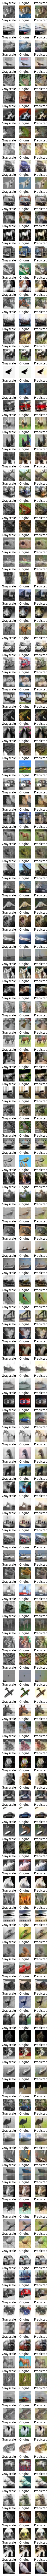

In [12]:
# Define the number of samples to generate
n_samples = 150
# Generate colorized versions of the first n_samples grayscale images in the test set
Y_hat = generator(X_test[:n_samples])

# Define the number of rows in the grid, which is equal to the number of samples
num_rows = len(Y_hat)

# Define the number of columns in the grid and the size of each image
num_cols = 3  # Number of columns in the grid
img_size = 1  # Size of each image in the grid

# Create a grid of subplots with num_rows rows and num_cols columns
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * img_size, num_rows * img_size))
fig.subplots_adjust(hspace=0.3, wspace=0.1)  # Adjust spacing between subplots

# Loop over the grayscale images, original color images, and colorized images
for row, (x, y, y_hat) in enumerate(zip(X_test[:n_samples], Y_test[:n_samples], Y_hat)):

    # Convert the original color image from Lab to RGB
    orig_lab = np.dstack((x, y * 128))
    orig_rgb = lab2rgb(orig_lab)

    # Convert the grayscale image from Lab to RGB
    grayscale_lab = np.dstack((x, np.zeros((IMAGE_SIZE, IMAGE_SIZE, 2))))
    grayscale_rgb = lab2rgb(grayscale_lab)

    # Convert the colorized image from Lab to RGB
    predicted_lab = np.dstack((x, y_hat * 128))
    predicted_rgb = lab2rgb(predicted_lab)

    # Display the grayscale image in the first column of the current row
    ax = axes[row, 0]  # Get the appropriate axis for the current subplot
    ax.axis('off')  # Turn off axis labels
    ax.imshow(grayscale_rgb)
    ax.set_title('Grayscale')

    # Display the original color image in the second column of the current row
    ax = axes[row, 1]  # Move to the next column for original RGB
    ax.axis('off')
    ax.imshow(orig_rgb)
    ax.set_title('Original')

    # Display the colorized image in the third column of the current row
    ax = axes[row, 2]  # Move to the next column for predicted colorized image
    ax.axis('off')
    ax.imshow(predicted_rgb)
    ax.set_title('Predicted')

    # Print the current row number to the console
    sys.stdout.flush()
    sys.stdout.write('\r{} / {}'.format(row + 1, num_rows))

# Hide empty subplots if any
for ax_row in axes:
    for ax in ax_row:
        if not ax.has_data():
            ax.axis('off')

# Adjust the padding between subplots
plt.tight_layout(pad=0.5)
# Save the figure as an image file
plt.savefig(os.path.join(WORKDIR, 'results', 'image_grid.png'))
# Display the figure
plt.show()

## Save the Generator and Discriminator Trained Models

In [13]:
# Save the checkpoints of the models and optimizers so that they can be loaded later
# Save the generator model in the SavedModel format
tf.saved_model.save(generator, os.path.join(WORKDIR, "generator-saved-model"))

# Save the discriminator model in the SavedModel format
tf.saved_model.save(discriminator, os.path.join(WORKDIR, "disciminator-saved-model"))

In [14]:
# from google.colab import files
# files.download()

# !zip -r /content/drive.zip /content/drive


  adding: content/drive/ (stored 0%)
  adding: content/drive/My Drive/ (stored 0%)
  adding: content/drive/My Drive/Colab Notebooks/ (stored 0%)
  adding: content/drive/My Drive/Colab Notebooks/Workspace/ (stored 0%)
  adding: content/drive/My Drive/Colab Notebooks/Workspace/X_test.npy (deflated 18%)
  adding: content/drive/My Drive/Colab Notebooks/Workspace/results/ (stored 0%)
  adding: content/drive/My Drive/Colab Notebooks/Workspace/results/image_grid.png (deflated 2%)
  adding: content/drive/My Drive/Colab Notebooks/Workspace/Y_test.npy (deflated 15%)
  adding: content/drive/My Drive/Colab Notebooks/Workspace/Y_train.npy (deflated 15%)
  adding: content/drive/My Drive/Colab Notebooks/Workspace/generator-saved-model/ (stored 0%)
  adding: content/drive/My Drive/Colab Notebooks/Workspace/generator-saved-model/assets/ (stored 0%)
  adding: content/drive/My Drive/Colab Notebooks/Workspace/generator-saved-model/variables/ (stored 0%)
  adding: content/drive/My Drive/Colab Notebooks/Wor